# Notebook to train CNNs

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id
from plotting_utils_torch import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from monai.networks.nets import ResNet
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


In [ ]:
NORMALIZATION = "mni_reg_CV" # Choose intensity normalization method: "minmax"
DATASET = "nc_ad" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 16 # Set batch size

USE_MASK = False # Set to True to use the ROI mask, False to use the whole brain

if USE_MASK:
    ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
else:
    ROI_MASK_PATH = None

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max, 
    mask_path=ROI_MASK_PATH
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataloader(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

Class map: {'nc': 0, 'ad': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/nc_ad/train...
    Found 559 files for class 'nc'
    Found 431 files for class 'ad'
Calculated Min: -0.41349178552627563, Max: 2.7118232250213623
Class map: {'nc': 0, 'ad': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/nc_ad/test...
    Found 140 files for class 'nc'
    Found 108 files for class 'ad'


torch.Size([1, 91, 109, 91])


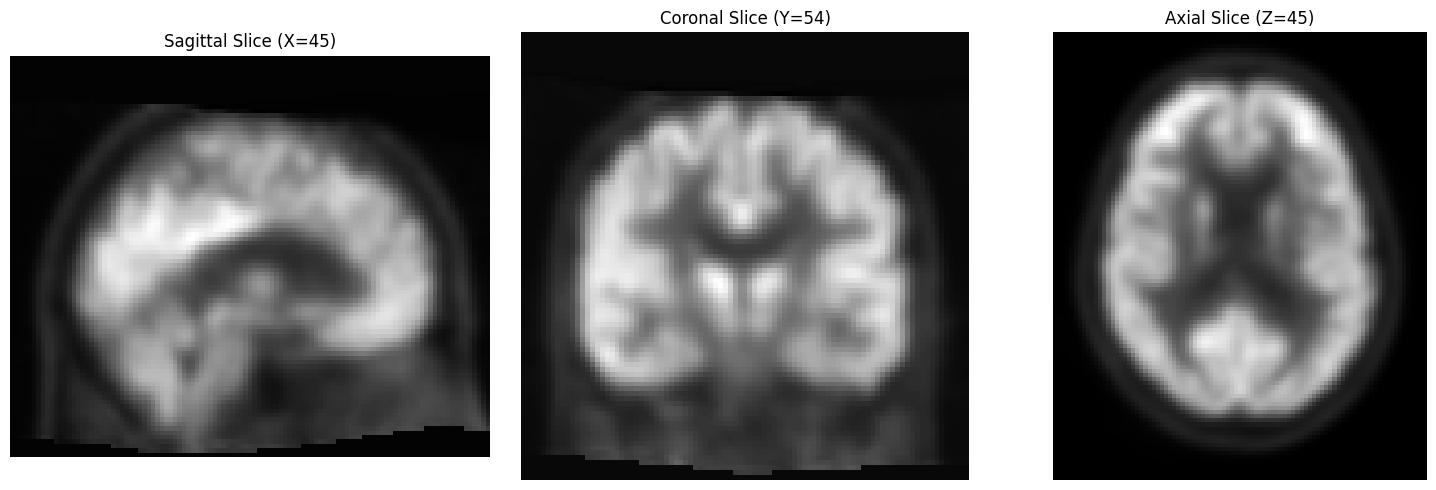

In [55]:
# Verify data with a test sample
i = 2
for data, label in test_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    break

In [56]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation

# para cosine decay
#learning_rates = [5e-4, 2e-4, 1e-4] # adicionar 1e-3? ver os resultados
#weight_decays = [5e-4, 2e-4, 1e-4]

#para fixed_lr
#learning_rates = [1e-5, 2e-5] # adicionar 4e-5 ou 5e-6 dependendo dos resultados
#weight_decays = [2e-4, 1e-4] # adicionar 4e-4 ou 5e-5 dependendo dos resultados

lr_scheduler = "fixed_lr" # Choose between "cosine_decay" or "fixed_lr"

if lr_scheduler == "cosine_decay":
    NUM_EPOCHS = 100
    EARLY_STOP_PATIENCE = 100
    T_max = 100
    eta_min = 0
else:
    NUM_EPOCHS = 120
    EARLY_STOP_PATIENCE = 100

learning_rates = [2e-7] # usar valores a volta do 1e-6 (ate agr a combinacao com l2=1e-4 ou 5e-4 pareceu a melhor com val loss min de 0.24 em 32 epochs)
weight_decays = [2e-4]

tuning_results = []
total_combinations = len(learning_rates) * len(weight_decays)
current_combination_no = 0

if ROI_MASK_PATH is None:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/" + DATASET + "/cosine_decay/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/" + DATASET + "/fixed_lr/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")
else:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/masked/" + DATASET + "/cosine_decay/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/masked/" + DATASET + "/fixed_lr/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

print("\nStarting Hyperparameter Tuning Grid Search...")
overall_start_time = time.time()

# Hyperparameter tuning loop
for current_lr in learning_rates:
    for current_wd in weight_decays: 
        current_combination_no += 1
        print("=" * 60)
        print(f"Testing Combination {current_combination_no}/{total_combinations}: LR={current_lr:.1e}, WeightDecay={current_wd:.0e}")
        print("=" * 60)
        start_time_combination = time.time()

        combo_dir_name = f"LR0_{current_lr:.1e}_WD_{current_wd:.0e}" 
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")

        current_combo_val_losses = []
        current_combo_val_accuracies = []
        current_combo_val_aucs = []
        current_combo_best_epoch = []

        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and WD={current_wd:.0e}...")
            start_time_fold = time.time()

            # Get paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify subject separation
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                 raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataloader(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )
            
            # Create fold validation dataset
            fold_val_data = create_dataloader(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )

            if fold_train_data is None or fold_val_data is None:
                 raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
             
            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            pos_weight_val = class_counts[0] / class_counts[1]
            pos_weight_val = torch.tensor([pos_weight_val], device=device)
            print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

            model = ResNet(
                block='basic',
                layers=[3, 4, 6, 3],
                block_inplanes=[64, 128, 256, 512],
                spatial_dims=3,
                n_input_channels=1,
                conv1_t_stride=2,
                num_classes=1,
                shortcut_type='B',
                bias_downsample = False
            )
            model.to(device)

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
            
            #optimizer = optim.AdamW(model.parameters(), lr=current_lr, weight_decay=current_wd)
            optimizer = optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_wd)
            #optimizer = optim.SGD(model.parameters(), lr=current_lr, weight_decay=current_wd, momentum=0.9, nesterov=True)
                        
            scheduler = None
            if lr_scheduler == "cosine_decay":
                print("\nUsing Cosine Annealing LR Scheduler.\n")
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    
            best_val_loss = float('inf')
            epochs_no_improve = 0
            best_epoch = 0
            best_model_state = None
            stopped_epoch = NUM_EPOCHS 

            # Initialize history for this fold
            history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}

            for epoch in tqdm(range(NUM_EPOCHS)):
                epoch_start_time = time.time()
                history['epoch'].append(epoch + 1)

                # Train phase
                model.train()
                running_loss = 0.0
                train_pred_probs = []
                train_targets = []
                
                for i, (inputs, labels) in enumerate(fold_train_data):
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    
                    optimizer.zero_grad()
                    
                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    
                    prob_outputs = torch.sigmoid(outputs)
                    train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                    train_targets.extend(labels.detach().cpu().numpy())
 
                train_targets = np.array(train_targets).flatten()
                train_pred_probs = np.array(train_pred_probs).flatten()
                
                # Calculate training metrics for the epoch
                train_loss = running_loss / len(fold_train_data.dataset)
                train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                train_auc = roc_auc_score(train_targets, train_pred_probs)
                history['train_loss'].append(train_loss)
                history['train_accuracy'].append(train_acc)
                history['train_auc'].append(train_auc)

                # Validation phase
                model.eval()
                val_running_loss = 0.0
                val_pred_probs = []
                val_targets = []

                with torch.inference_mode():
                    for inputs, labels in fold_val_data:
                        inputs = inputs.to(device)
                        labels = labels.float().unsqueeze(1).to(device)

                        # Mixed precision
                        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        val_running_loss += loss.item() * inputs.size(0)

                        prob_outputs = torch.sigmoid(outputs)
                        val_pred_probs.extend(prob_outputs.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                        
                val_targets = np.array(val_targets).flatten()
                val_pred_probs = np.array(val_pred_probs).flatten()

                # Calculate validation metrics for the epoch
                val_loss = val_running_loss / len(fold_val_data.dataset)
                val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                val_auc = roc_auc_score(val_targets, val_pred_probs)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_auc'].append(val_auc)

                # Print Epoch Summary
                epoch_duration = time.time() - epoch_start_time
                print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                      f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | "
                      f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
                
                if scheduler:
                    scheduler.step()

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    # Save the best model state
                    best_model_state = model.state_dict()
                    best_epoch = epoch + 1
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= EARLY_STOP_PATIENCE:
                    model.load_state_dict(best_model_state)
                    stopped_epoch = epoch + 1
                    print(f"\nEarly stopping triggered. Restoring best model weights from epoch {stopped_epoch - epochs_no_improve}.\n")
                    break
            
            # Restore the best model state if early stopping was not triggered
            if epochs_no_improve < EARLY_STOP_PATIENCE:
                print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                model.load_state_dict(best_model_state)
            
            # Save fold history and plots
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history)
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            history_df.to_csv(history_csv_path, index=False)
            plot_loss_curves(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = np.argmin(history['val_loss'])
            best_epoch = best_epoch_index + 1
            val_loss_best = history['val_loss'][best_epoch_index]
            val_accuracy_best = history['val_accuracy'][best_epoch_index]
            val_auc_best = history['val_auc'][best_epoch_index]
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}")

            # Append results for this fold
            current_combo_val_losses.append(val_loss_best)
            current_combo_val_accuracies.append(val_accuracy_best)
            current_combo_val_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)
            
            optimizer_name = optimizer.__class__.__name__
            optimizer_params = {
                'lr': float(current_lr),
                'weight_decay': float(current_wd)
            }
        
            # Free resources
            del model, optimizer, criterion, scheduler, fold_train_data, fold_val_data, history, history_df, best_model_state
            if device.type == 'cuda':
                torch.cuda.empty_cache() 
            gc.collect() 
            
            
            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1

        # Aggregate results across folds
        avg_loss = np.mean(current_combo_val_losses)
        std_loss = np.std(current_combo_val_losses)
        avg_acc = np.mean(current_combo_val_accuracies)
        std_acc = np.std(current_combo_val_accuracies)
        avg_auc = np.mean(current_combo_val_aucs)
        std_auc = np.std(current_combo_val_aucs)

        print("-" * 50)
        print(f"Results for LR={current_lr}, WeightDecay={current_wd} (Across {N_SPLITS} Folds):")
        print(f"  Avg Val Loss: {avg_loss:.4f} +/- {std_loss:.4f}")
        print(f"  Avg Val Acc:  {avg_acc:.4f} +/- {std_acc:.4f}")
        print(f"  Avg Val AUC:  {avg_auc:.4f} +/- {std_auc:.4f}")
        print("-" * 50)

        # Store results
        
        combo_average_results = {
            'learning_rate': current_lr,
            'weight_decay': current_wd,
            'avg_val_loss': avg_loss,
            'std_val_loss': std_loss,
            'avg_val_accuracy': avg_acc,
            'std_val_accuracy': std_acc,
            'avg_val_auc': avg_auc,
            'std_val_auc': std_auc,
            'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
            'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
            'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
            'best_epoch_per_fold': list(current_combo_best_epoch)
        }
        
        tuning_results.append(combo_average_results)
        
        results_df = pd.DataFrame(combo_average_results)
        display_cols = list(combo_average_results.keys())
        
        results_file_path = os.path.join(combo_results_dir, "resultados.txt")
        with open(results_file_path, "w") as f:
            print("\nTuning Results Summary:", file=f)
            print(results_df[display_cols].round(6).to_string(index=False), file=f)

            print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)
        
        training_config = {
            "num_folds": N_SPLITS,
            "num_epochs": NUM_EPOCHS,
            "early_stop_patience": EARLY_STOP_PATIENCE,
            "lr_scheduler": lr_scheduler,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(optimizer_params['lr']),
                "weight_decay": float(optimizer_params['weight_decay'])
            },
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(combo_results_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)

        end_time_combination = time.time()
        print(f"Combination {current_combination_no} finished in {end_time_combination - start_time_combination:.2f} seconds.")
        


Results will be saved to: /home/diogommiranda/tese/outputs/torch/full_brain/nc_ad/fixed_lr/

Starting Hyperparameter Tuning Grid Search...
Testing Combination 1/1: LR=2.0e-07, WeightDecay=2e-04
  Saving results for this combo to: /home/diogommiranda/tese/outputs/torch/full_brain/nc_ad/fixed_lr/LR0_2.0e-07_WD_2e-04
------------------------------------------------------------
Training Fold 1/5 for LR=2.0e-07 and WD=2e-04...
  Train samples: 787, Validation samples: 203
Calculated Min: -0.32768693566322327, Max: 2.7118232250213623
  Fold train label counts: {0: 422, 1: 365}
  Calculated pos_weight for BCEWithLogitsLoss: 1.1562


  1%|          | 1/120 [00:09<19:19,  9.75s/it]

    Epoch 1/120 [9.74s] - Train Loss: 0.75094, Train Acc: 0.46379 | Val Loss: 0.76362, Val Acc: 0.32512


  2%|▏         | 2/120 [00:19<18:48,  9.56s/it]

    Epoch 2/120 [9.43s] - Train Loss: 0.72261, Train Acc: 0.46887 | Val Loss: 0.73261, Val Acc: 0.33498


  2%|▎         | 3/120 [00:29<19:29, 10.00s/it]

    Epoch 3/120 [10.52s] - Train Loss: 0.70103, Train Acc: 0.55909 | Val Loss: 0.70212, Val Acc: 0.55172


  3%|▎         | 4/120 [00:39<18:51,  9.76s/it]

    Epoch 4/120 [9.38s] - Train Loss: 0.68248, Train Acc: 0.70902 | Val Loss: 0.68842, Val Acc: 0.60099


  4%|▍         | 5/120 [00:48<18:27,  9.63s/it]

    Epoch 5/120 [9.41s] - Train Loss: 0.65864, Train Acc: 0.81067 | Val Loss: 0.65341, Val Acc: 0.74877


  5%|▌         | 6/120 [00:59<18:53,  9.95s/it]

    Epoch 6/120 [10.55s] - Train Loss: 0.63841, Train Acc: 0.85133 | Val Loss: 0.63088, Val Acc: 0.77833


  6%|▌         | 7/120 [01:08<18:28,  9.81s/it]

    Epoch 7/120 [9.51s] - Train Loss: 0.62316, Train Acc: 0.85006 | Val Loss: 0.60730, Val Acc: 0.80788


  7%|▋         | 8/120 [01:18<18:06,  9.70s/it]

    Epoch 8/120 [9.46s] - Train Loss: 0.59928, Train Acc: 0.86023 | Val Loss: 0.57644, Val Acc: 0.86207


  8%|▊         | 9/120 [01:27<17:47,  9.62s/it]

    Epoch 9/120 [9.44s] - Train Loss: 0.57354, Train Acc: 0.87802 | Val Loss: 0.55444, Val Acc: 0.84729


  8%|▊         | 10/120 [01:38<18:09,  9.90s/it]

    Epoch 10/120 [10.54s] - Train Loss: 0.54827, Train Acc: 0.86277 | Val Loss: 0.52536, Val Acc: 0.87685


  9%|▉         | 11/120 [01:47<17:43,  9.76s/it]

    Epoch 11/120 [9.43s] - Train Loss: 0.52475, Train Acc: 0.87675 | Val Loss: 0.49811, Val Acc: 0.87192


 10%|█         | 12/120 [01:56<17:22,  9.66s/it]

    Epoch 12/120 [9.42s] - Train Loss: 0.49588, Train Acc: 0.88564 | Val Loss: 0.49704, Val Acc: 0.84729


 11%|█         | 13/120 [02:07<17:44,  9.95s/it]

    Epoch 13/120 [10.63s] - Train Loss: 0.46690, Train Acc: 0.89962 | Val Loss: 0.45650, Val Acc: 0.87192


 12%|█▏        | 14/120 [02:16<17:19,  9.81s/it]

    Epoch 14/120 [9.47s] - Train Loss: 0.45791, Train Acc: 0.88056 | Val Loss: 0.45869, Val Acc: 0.84729


 12%|█▎        | 15/120 [02:26<16:56,  9.68s/it]

    Epoch 15/120 [9.38s] - Train Loss: 0.42529, Train Acc: 0.89581 | Val Loss: 0.40468, Val Acc: 0.88670


 13%|█▎        | 16/120 [02:36<17:12,  9.93s/it]

    Epoch 16/120 [10.51s] - Train Loss: 0.40691, Train Acc: 0.88056 | Val Loss: 0.41874, Val Acc: 0.84729


 14%|█▍        | 17/120 [02:46<16:45,  9.77s/it]

    Epoch 17/120 [9.39s] - Train Loss: 0.39781, Train Acc: 0.87929 | Val Loss: 0.39432, Val Acc: 0.85714


 15%|█▌        | 18/120 [02:55<16:24,  9.65s/it]

    Epoch 18/120 [9.39s] - Train Loss: 0.37357, Train Acc: 0.88183 | Val Loss: 0.35402, Val Acc: 0.90640


 16%|█▌        | 19/120 [03:04<16:05,  9.56s/it]

    Epoch 19/120 [9.35s] - Train Loss: 0.33151, Train Acc: 0.90724 | Val Loss: 0.34423, Val Acc: 0.90148


 17%|█▋        | 20/120 [03:15<16:25,  9.85s/it]

    Epoch 20/120 [10.52s] - Train Loss: 0.33552, Train Acc: 0.90724 | Val Loss: 0.37090, Val Acc: 0.85222


 18%|█▊        | 21/120 [03:24<16:01,  9.71s/it]

    Epoch 21/120 [9.37s] - Train Loss: 0.33441, Train Acc: 0.89708 | Val Loss: 0.41065, Val Acc: 0.81773


 18%|█▊        | 22/120 [03:34<15:41,  9.60s/it]

    Epoch 22/120 [9.36s] - Train Loss: 0.28903, Train Acc: 0.91995 | Val Loss: 0.31702, Val Acc: 0.91133


 19%|█▉        | 23/120 [03:44<16:04,  9.95s/it]

    Epoch 23/120 [10.74s] - Train Loss: 0.29542, Train Acc: 0.90851 | Val Loss: 0.33764, Val Acc: 0.86700


 20%|██        | 24/120 [03:54<15:39,  9.79s/it]

    Epoch 24/120 [9.42s] - Train Loss: 0.26613, Train Acc: 0.91487 | Val Loss: 0.30209, Val Acc: 0.90640


 21%|██        | 25/120 [04:03<15:18,  9.67s/it]

    Epoch 25/120 [9.38s] - Train Loss: 0.28537, Train Acc: 0.90089 | Val Loss: 0.28426, Val Acc: 0.91626


 22%|██▏       | 26/120 [04:13<14:57,  9.55s/it]

    Epoch 26/120 [9.26s] - Train Loss: 0.25817, Train Acc: 0.90343 | Val Loss: 0.29881, Val Acc: 0.90640


 22%|██▎       | 27/120 [04:22<14:43,  9.50s/it]

    Epoch 27/120 [9.39s] - Train Loss: 0.24043, Train Acc: 0.91868 | Val Loss: 0.29789, Val Acc: 0.90148


 23%|██▎       | 28/120 [04:33<15:18,  9.98s/it]

    Epoch 28/120 [11.12s] - Train Loss: 0.23207, Train Acc: 0.92249 | Val Loss: 0.27997, Val Acc: 0.92118


 24%|██▍       | 29/120 [04:43<14:56,  9.86s/it]

    Epoch 29/120 [9.56s] - Train Loss: 0.21624, Train Acc: 0.93139 | Val Loss: 0.31423, Val Acc: 0.86700


 25%|██▌       | 30/120 [04:52<14:45,  9.84s/it]

    Epoch 30/120 [9.80s] - Train Loss: 0.21791, Train Acc: 0.93011 | Val Loss: 0.26745, Val Acc: 0.91626


 26%|██▌       | 31/120 [05:02<14:33,  9.81s/it]

    Epoch 31/120 [9.75s] - Train Loss: 0.18835, Train Acc: 0.94917 | Val Loss: 0.27557, Val Acc: 0.89655


 27%|██▋       | 32/120 [05:13<15:01, 10.24s/it]

    Epoch 32/120 [11.24s] - Train Loss: 0.22295, Train Acc: 0.92249 | Val Loss: 0.28800, Val Acc: 0.89655


 28%|██▊       | 33/120 [05:23<14:34, 10.05s/it]

    Epoch 33/120 [9.60s] - Train Loss: 0.19641, Train Acc: 0.93393 | Val Loss: 0.32295, Val Acc: 0.87685


 28%|██▊       | 34/120 [05:32<14:08,  9.87s/it]

    Epoch 34/120 [9.43s] - Train Loss: 0.22933, Train Acc: 0.92503 | Val Loss: 0.30935, Val Acc: 0.89163


 29%|██▉       | 35/120 [05:43<14:19, 10.12s/it]

    Epoch 35/120 [10.70s] - Train Loss: 0.19482, Train Acc: 0.93774 | Val Loss: 0.28012, Val Acc: 0.91626


 30%|███       | 36/120 [05:53<13:51,  9.90s/it]

    Epoch 36/120 [9.40s] - Train Loss: 0.18234, Train Acc: 0.94409 | Val Loss: 0.25352, Val Acc: 0.92118


 31%|███       | 37/120 [06:02<13:28,  9.74s/it]

    Epoch 37/120 [9.36s] - Train Loss: 0.16041, Train Acc: 0.95299 | Val Loss: 0.41700, Val Acc: 0.79803


 32%|███▏      | 38/120 [06:12<13:25,  9.83s/it]

    Epoch 38/120 [10.03s] - Train Loss: 0.15346, Train Acc: 0.95044 | Val Loss: 0.25481, Val Acc: 0.91133


 32%|███▎      | 39/120 [06:22<13:25,  9.95s/it]

    Epoch 39/120 [10.23s] - Train Loss: 0.20320, Train Acc: 0.93139 | Val Loss: 0.36312, Val Acc: 0.83251


 33%|███▎      | 40/120 [06:33<13:45, 10.32s/it]

    Epoch 40/120 [11.18s] - Train Loss: 0.16974, Train Acc: 0.94282 | Val Loss: 0.32959, Val Acc: 0.85222


 34%|███▍      | 41/120 [06:43<13:17, 10.10s/it]

    Epoch 41/120 [9.57s] - Train Loss: 0.16621, Train Acc: 0.94409 | Val Loss: 0.32847, Val Acc: 0.85222


 35%|███▌      | 42/120 [06:53<13:01, 10.02s/it]

    Epoch 42/120 [9.85s] - Train Loss: 0.13919, Train Acc: 0.95680 | Val Loss: 0.26678, Val Acc: 0.91626


 36%|███▌      | 43/120 [07:04<13:18, 10.37s/it]

    Epoch 43/120 [11.17s] - Train Loss: 0.12497, Train Acc: 0.96823 | Val Loss: 0.28176, Val Acc: 0.90148


 37%|███▋      | 44/120 [07:14<12:59, 10.26s/it]

    Epoch 44/120 [9.99s] - Train Loss: 0.14317, Train Acc: 0.96188 | Val Loss: 0.25016, Val Acc: 0.92118


 38%|███▊      | 45/120 [07:24<12:41, 10.16s/it]

    Epoch 45/120 [9.93s] - Train Loss: 0.11473, Train Acc: 0.96315 | Val Loss: 0.30915, Val Acc: 0.87685


 38%|███▊      | 46/120 [07:35<12:46, 10.35s/it]

    Epoch 46/120 [10.80s] - Train Loss: 0.13662, Train Acc: 0.95426 | Val Loss: 0.26177, Val Acc: 0.92118


 39%|███▉      | 47/120 [07:44<12:15, 10.07s/it]

    Epoch 47/120 [9.43s] - Train Loss: 0.09710, Train Acc: 0.97967 | Val Loss: 0.25693, Val Acc: 0.91626


 40%|████      | 48/120 [07:54<11:50,  9.87s/it]

    Epoch 48/120 [9.41s] - Train Loss: 0.14088, Train Acc: 0.94790 | Val Loss: 0.25150, Val Acc: 0.92118


 41%|████      | 49/120 [08:03<11:33,  9.77s/it]

    Epoch 49/120 [9.53s] - Train Loss: 0.11017, Train Acc: 0.96950 | Val Loss: 0.25977, Val Acc: 0.92118


 42%|████▏     | 50/120 [08:14<11:41, 10.02s/it]

    Epoch 50/120 [10.61s] - Train Loss: 0.09689, Train Acc: 0.97840 | Val Loss: 0.24141, Val Acc: 0.92118


 42%|████▎     | 51/120 [08:23<11:18,  9.83s/it]

    Epoch 51/120 [9.39s] - Train Loss: 0.11044, Train Acc: 0.96188 | Val Loss: 0.24018, Val Acc: 0.92118


 43%|████▎     | 52/120 [08:32<10:59,  9.70s/it]

    Epoch 52/120 [9.38s] - Train Loss: 0.13765, Train Acc: 0.94536 | Val Loss: 0.24826, Val Acc: 0.92118


 44%|████▍     | 53/120 [08:43<11:06,  9.95s/it]

    Epoch 53/120 [10.55s] - Train Loss: 0.10692, Train Acc: 0.96061 | Val Loss: 0.30195, Val Acc: 0.87685


 45%|████▌     | 54/120 [08:53<10:49,  9.85s/it]

    Epoch 54/120 [9.59s] - Train Loss: 0.13029, Train Acc: 0.94663 | Val Loss: 0.25319, Val Acc: 0.92118


 46%|████▌     | 55/120 [09:02<10:30,  9.69s/it]

    Epoch 55/120 [9.34s] - Train Loss: 0.12930, Train Acc: 0.95553 | Val Loss: 0.28717, Val Acc: 0.90148


 47%|████▋     | 56/120 [09:11<10:15,  9.61s/it]

    Epoch 56/120 [9.41s] - Train Loss: 0.13006, Train Acc: 0.95172 | Val Loss: 0.23583, Val Acc: 0.92611


 48%|████▊     | 57/120 [09:22<10:26,  9.95s/it]

    Epoch 57/120 [10.75s] - Train Loss: 0.10586, Train Acc: 0.96569 | Val Loss: 0.25313, Val Acc: 0.91626


 48%|████▊     | 58/120 [09:31<10:04,  9.75s/it]

    Epoch 58/120 [9.28s] - Train Loss: 0.10305, Train Acc: 0.96442 | Val Loss: 0.29292, Val Acc: 0.89655


 49%|████▉     | 59/120 [09:41<09:48,  9.65s/it]

    Epoch 59/120 [9.42s] - Train Loss: 0.12231, Train Acc: 0.95553 | Val Loss: 0.24596, Val Acc: 0.92611


 50%|█████     | 60/120 [09:52<09:58,  9.98s/it]

    Epoch 60/120 [10.76s] - Train Loss: 0.11089, Train Acc: 0.94917 | Val Loss: 0.27621, Val Acc: 0.91133


 51%|█████     | 61/120 [10:01<09:40,  9.84s/it]

    Epoch 61/120 [9.51s] - Train Loss: 0.09278, Train Acc: 0.96442 | Val Loss: 0.24309, Val Acc: 0.92118


 52%|█████▏    | 62/120 [10:10<09:21,  9.69s/it]

    Epoch 62/120 [9.32s] - Train Loss: 0.09184, Train Acc: 0.97205 | Val Loss: 0.26328, Val Acc: 0.90640


 52%|█████▎    | 63/120 [10:21<09:31, 10.03s/it]

    Epoch 63/120 [10.85s] - Train Loss: 0.11776, Train Acc: 0.95807 | Val Loss: 0.30877, Val Acc: 0.85222


 53%|█████▎    | 64/120 [10:31<09:16,  9.94s/it]

    Epoch 64/120 [9.73s] - Train Loss: 0.07141, Train Acc: 0.97840 | Val Loss: 0.25348, Val Acc: 0.92118


 54%|█████▍    | 65/120 [10:40<08:56,  9.75s/it]

    Epoch 65/120 [9.29s] - Train Loss: 0.08884, Train Acc: 0.97586 | Val Loss: 0.23587, Val Acc: 0.92611


 55%|█████▌    | 66/120 [10:50<08:40,  9.64s/it]

    Epoch 66/120 [9.39s] - Train Loss: 0.08989, Train Acc: 0.96442 | Val Loss: 0.28580, Val Acc: 0.89655


 56%|█████▌    | 67/120 [11:01<08:59, 10.18s/it]

    Epoch 67/120 [11.45s] - Train Loss: 0.10377, Train Acc: 0.96442 | Val Loss: 0.24442, Val Acc: 0.92611


 57%|█████▋    | 68/120 [11:11<08:46, 10.13s/it]

    Epoch 68/120 [9.99s] - Train Loss: 0.08916, Train Acc: 0.97713 | Val Loss: 0.23922, Val Acc: 0.92118


 57%|█████▊    | 69/120 [11:22<08:41, 10.22s/it]

    Epoch 69/120 [10.44s] - Train Loss: 0.06290, Train Acc: 0.98602 | Val Loss: 0.24227, Val Acc: 0.91626


 58%|█████▊    | 70/120 [11:33<08:45, 10.51s/it]

    Epoch 70/120 [11.19s] - Train Loss: 0.07640, Train Acc: 0.98094 | Val Loss: 0.25764, Val Acc: 0.92118


 59%|█████▉    | 71/120 [11:42<08:17, 10.16s/it]

    Epoch 71/120 [9.34s] - Train Loss: 0.06420, Train Acc: 0.98094 | Val Loss: 0.24549, Val Acc: 0.93103


 60%|██████    | 72/120 [11:51<07:54,  9.88s/it]

    Epoch 72/120 [9.22s] - Train Loss: 0.07259, Train Acc: 0.97713 | Val Loss: 0.25392, Val Acc: 0.92611


 61%|██████    | 73/120 [12:02<07:57, 10.15s/it]

    Epoch 73/120 [10.79s] - Train Loss: 0.08402, Train Acc: 0.97078 | Val Loss: 0.28535, Val Acc: 0.89655


 62%|██████▏   | 74/120 [12:12<07:37,  9.95s/it]

    Epoch 74/120 [9.48s] - Train Loss: 0.07173, Train Acc: 0.97332 | Val Loss: 0.31450, Val Acc: 0.88670


 62%|██████▎   | 75/120 [12:21<07:18,  9.75s/it]

    Epoch 75/120 [9.29s] - Train Loss: 0.07474, Train Acc: 0.97586 | Val Loss: 0.25506, Val Acc: 0.92118


 63%|██████▎   | 76/120 [12:30<07:05,  9.67s/it]

    Epoch 76/120 [9.48s] - Train Loss: 0.07978, Train Acc: 0.97713 | Val Loss: 0.24900, Val Acc: 0.92118


 64%|██████▍   | 77/120 [12:41<07:12, 10.07s/it]

    Epoch 77/120 [10.98s] - Train Loss: 0.08257, Train Acc: 0.97459 | Val Loss: 0.27949, Val Acc: 0.89163


 65%|██████▌   | 78/120 [12:51<06:54,  9.87s/it]

    Epoch 78/120 [9.42s] - Train Loss: 0.09647, Train Acc: 0.96950 | Val Loss: 0.25324, Val Acc: 0.91626


 66%|██████▌   | 79/120 [13:00<06:36,  9.68s/it]

    Epoch 79/120 [9.23s] - Train Loss: 0.09695, Train Acc: 0.97078 | Val Loss: 0.30500, Val Acc: 0.87685


 67%|██████▋   | 80/120 [13:11<06:40, 10.01s/it]

    Epoch 80/120 [10.78s] - Train Loss: 0.08968, Train Acc: 0.96823 | Val Loss: 0.30077, Val Acc: 0.88670


 68%|██████▊   | 81/120 [13:20<06:24,  9.86s/it]

    Epoch 81/120 [9.50s] - Train Loss: 0.07627, Train Acc: 0.97459 | Val Loss: 0.28583, Val Acc: 0.89655


 68%|██████▊   | 82/120 [13:30<06:08,  9.69s/it]

    Epoch 82/120 [9.30s] - Train Loss: 0.07648, Train Acc: 0.98094 | Val Loss: 0.48388, Val Acc: 0.80788


 69%|██████▉   | 83/120 [13:39<05:57,  9.66s/it]

    Epoch 83/120 [9.60s] - Train Loss: 0.06628, Train Acc: 0.97967 | Val Loss: 0.31623, Val Acc: 0.87192


 70%|███████   | 84/120 [13:50<06:00, 10.01s/it]

    Epoch 84/120 [10.82s] - Train Loss: 0.09225, Train Acc: 0.97332 | Val Loss: 0.36638, Val Acc: 0.84236


 71%|███████   | 85/120 [13:59<05:42,  9.78s/it]

    Epoch 85/120 [9.26s] - Train Loss: 0.09140, Train Acc: 0.97840 | Val Loss: 0.37205, Val Acc: 0.84236


 72%|███████▏  | 86/120 [14:09<05:29,  9.69s/it]

    Epoch 86/120 [9.47s] - Train Loss: 0.08363, Train Acc: 0.97205 | Val Loss: 0.25572, Val Acc: 0.92611


 72%|███████▎  | 87/120 [14:20<05:32, 10.07s/it]

    Epoch 87/120 [10.97s] - Train Loss: 0.09774, Train Acc: 0.97713 | Val Loss: 0.28165, Val Acc: 0.91133


 73%|███████▎  | 88/120 [14:29<05:13,  9.81s/it]

    Epoch 88/120 [9.19s] - Train Loss: 0.08123, Train Acc: 0.97586 | Val Loss: 0.44952, Val Acc: 0.82266


 74%|███████▍  | 89/120 [14:38<05:00,  9.69s/it]

    Epoch 89/120 [9.41s] - Train Loss: 0.07445, Train Acc: 0.98094 | Val Loss: 0.30133, Val Acc: 0.88670


 75%|███████▌  | 90/120 [14:48<04:50,  9.67s/it]

    Epoch 90/120 [9.62s] - Train Loss: 0.10198, Train Acc: 0.97205 | Val Loss: 0.26538, Val Acc: 0.92118


 76%|███████▌  | 91/120 [14:59<04:48,  9.96s/it]

    Epoch 91/120 [10.62s] - Train Loss: 0.08262, Train Acc: 0.97586 | Val Loss: 0.30865, Val Acc: 0.88670


 77%|███████▋  | 92/120 [15:08<04:34,  9.81s/it]

    Epoch 92/120 [9.45s] - Train Loss: 0.06679, Train Acc: 0.98094 | Val Loss: 0.29140, Val Acc: 0.89655


 78%|███████▊  | 93/120 [15:17<04:21,  9.69s/it]

    Epoch 93/120 [9.41s] - Train Loss: 0.07831, Train Acc: 0.97459 | Val Loss: 0.24693, Val Acc: 0.92611


 78%|███████▊  | 94/120 [15:28<04:20, 10.01s/it]

    Epoch 94/120 [10.77s] - Train Loss: 0.08608, Train Acc: 0.97713 | Val Loss: 0.29116, Val Acc: 0.89655


 79%|███████▉  | 95/120 [15:37<04:04,  9.79s/it]

    Epoch 95/120 [9.29s] - Train Loss: 0.06645, Train Acc: 0.97967 | Val Loss: 0.30277, Val Acc: 0.87685


 80%|████████  | 96/120 [15:47<03:50,  9.62s/it]

    Epoch 96/120 [9.22s] - Train Loss: 0.06285, Train Acc: 0.98856 | Val Loss: 0.25203, Val Acc: 0.92611


 81%|████████  | 97/120 [15:57<03:49,  9.99s/it]

    Epoch 97/120 [10.84s] - Train Loss: 0.06628, Train Acc: 0.98348 | Val Loss: 0.42504, Val Acc: 0.82266


 82%|████████▏ | 98/120 [16:07<03:35,  9.77s/it]

    Epoch 98/120 [9.27s] - Train Loss: 0.08627, Train Acc: 0.97078 | Val Loss: 0.25103, Val Acc: 0.93103


 82%|████████▎ | 99/120 [16:16<03:22,  9.65s/it]

    Epoch 99/120 [9.35s] - Train Loss: 0.06887, Train Acc: 0.97332 | Val Loss: 0.30713, Val Acc: 0.87685


 83%|████████▎ | 100/120 [16:26<03:12,  9.61s/it]

    Epoch 100/120 [9.53s] - Train Loss: 0.07923, Train Acc: 0.98094 | Val Loss: 0.27042, Val Acc: 0.91626


 84%|████████▍ | 101/120 [16:37<03:09,  9.99s/it]

    Epoch 101/120 [10.86s] - Train Loss: 0.09233, Train Acc: 0.97967 | Val Loss: 0.37659, Val Acc: 0.84236


 85%|████████▌ | 102/120 [16:46<02:55,  9.76s/it]

    Epoch 102/120 [9.25s] - Train Loss: 0.06358, Train Acc: 0.98094 | Val Loss: 0.28463, Val Acc: 0.90148


 86%|████████▌ | 103/120 [16:56<02:46,  9.79s/it]

    Epoch 103/120 [9.83s] - Train Loss: 0.06224, Train Acc: 0.98602 | Val Loss: 0.24685, Val Acc: 0.92611


 87%|████████▋ | 104/120 [17:07<02:43, 10.20s/it]

    Epoch 104/120 [11.15s] - Train Loss: 0.06398, Train Acc: 0.98475 | Val Loss: 0.25973, Val Acc: 0.92118


 88%|████████▊ | 105/120 [17:16<02:29,  9.93s/it]

    Epoch 105/120 [9.33s] - Train Loss: 0.07323, Train Acc: 0.98348 | Val Loss: 0.25804, Val Acc: 0.92611


 88%|████████▊ | 106/120 [17:26<02:18,  9.87s/it]

    Epoch 106/120 [9.72s] - Train Loss: 0.06441, Train Acc: 0.98729 | Val Loss: 0.29375, Val Acc: 0.88177


 89%|████████▉ | 107/120 [17:37<02:13, 10.26s/it]

    Epoch 107/120 [11.18s] - Train Loss: 0.05054, Train Acc: 0.98983 | Val Loss: 0.34861, Val Acc: 0.85714


 90%|█████████ | 108/120 [17:46<02:00, 10.00s/it]

    Epoch 108/120 [9.39s] - Train Loss: 0.06429, Train Acc: 0.98602 | Val Loss: 0.27284, Val Acc: 0.91626


 91%|█████████ | 109/120 [17:56<01:48,  9.90s/it]

    Epoch 109/120 [9.67s] - Train Loss: 0.07805, Train Acc: 0.97967 | Val Loss: 0.36120, Val Acc: 0.85714


 92%|█████████▏| 110/120 [18:06<01:38,  9.81s/it]

    Epoch 110/120 [9.61s] - Train Loss: 0.06638, Train Acc: 0.98475 | Val Loss: 0.26197, Val Acc: 0.92611


 92%|█████████▎| 111/120 [18:17<01:31, 10.16s/it]

    Epoch 111/120 [10.96s] - Train Loss: 0.06023, Train Acc: 0.98729 | Val Loss: 0.32926, Val Acc: 0.86700


 93%|█████████▎| 112/120 [18:26<01:19,  9.98s/it]

    Epoch 112/120 [9.55s] - Train Loss: 0.06409, Train Acc: 0.98729 | Val Loss: 0.24710, Val Acc: 0.92611


 94%|█████████▍| 113/120 [18:36<01:09,  9.96s/it]

    Epoch 113/120 [9.93s] - Train Loss: 0.06270, Train Acc: 0.98475 | Val Loss: 0.27566, Val Acc: 0.92118


 95%|█████████▌| 114/120 [18:47<01:01, 10.31s/it]

    Epoch 114/120 [11.13s] - Train Loss: 0.06167, Train Acc: 0.98729 | Val Loss: 0.30838, Val Acc: 0.88670


 96%|█████████▌| 115/120 [18:57<00:50, 10.11s/it]

    Epoch 115/120 [9.63s] - Train Loss: 0.07338, Train Acc: 0.97840 | Val Loss: 0.32811, Val Acc: 0.87685


 97%|█████████▋| 116/120 [19:07<00:40, 10.12s/it]

    Epoch 116/120 [10.14s] - Train Loss: 0.05113, Train Acc: 0.98475 | Val Loss: 0.38536, Val Acc: 0.84729


 98%|█████████▊| 117/120 [19:18<00:31, 10.47s/it]

    Epoch 117/120 [11.29s] - Train Loss: 0.05357, Train Acc: 0.98729 | Val Loss: 0.40224, Val Acc: 0.83744


 98%|█████████▊| 118/120 [19:27<00:20, 10.08s/it]

    Epoch 118/120 [9.18s] - Train Loss: 0.06244, Train Acc: 0.98856 | Val Loss: 0.28406, Val Acc: 0.90640


 99%|█████████▉| 119/120 [19:37<00:09,  9.91s/it]

    Epoch 119/120 [9.50s] - Train Loss: 0.04975, Train Acc: 0.99238 | Val Loss: 0.25171, Val Acc: 0.93596


100%|██████████| 120/120 [19:46<00:00,  9.89s/it]

    Epoch 120/120 [9.37s] - Train Loss: 0.08584, Train Acc: 0.97459 | Val Loss: 0.27753, Val Acc: 0.90148
Training completed for 120 epochs. Restoring best model weights from epoch 56.


    Fold 1 - Best Epoch 56, Val Loss: 0.2358, Acc: 0.9261, AUC: 0.9620
    Fold 1 finished in 1189.76 seconds.
------------------------------------------------------------
Training Fold 2/5 for LR=2.0e-07 and WD=2e-04...
  Train samples: 789, Validation samples: 201
Calculated Min: -0.41349178552627563, Max: 2.7118232250213623
  Fold train label counts: {0: 443, 1: 346}
  Calculated pos_weight for BCEWithLogitsLoss: 1.2803


  1%|          | 1/120 [00:09<19:00,  9.58s/it]

    Epoch 1/120 [9.58s] - Train Loss: 0.78415, Train Acc: 0.43853 | Val Loss: 0.77797, Val Acc: 0.42786


  2%|▏         | 2/120 [00:19<18:53,  9.60s/it]

    Epoch 2/120 [9.62s] - Train Loss: 0.75715, Train Acc: 0.45247 | Val Loss: 0.75814, Val Acc: 0.46766


  2%|▎         | 3/120 [00:28<18:38,  9.56s/it]

    Epoch 3/120 [9.51s] - Train Loss: 0.72737, Train Acc: 0.55894 | Val Loss: 0.73745, Val Acc: 0.58706


  3%|▎         | 4/120 [00:39<19:33, 10.12s/it]

    Epoch 4/120 [10.97s] - Train Loss: 0.70745, Train Acc: 0.71863 | Val Loss: 0.71662, Val Acc: 0.70647


  4%|▍         | 5/120 [00:49<19:07,  9.97s/it]

    Epoch 5/120 [9.72s] - Train Loss: 0.68456, Train Acc: 0.77693 | Val Loss: 0.70119, Val Acc: 0.72637


  5%|▌         | 6/120 [00:58<18:32,  9.76s/it]

    Epoch 6/120 [9.33s] - Train Loss: 0.66455, Train Acc: 0.82129 | Val Loss: 0.68092, Val Acc: 0.77114


  6%|▌         | 7/120 [01:09<18:52, 10.02s/it]

    Epoch 7/120 [10.56s] - Train Loss: 0.63743, Train Acc: 0.84918 | Val Loss: 0.66559, Val Acc: 0.75622


  7%|▋         | 8/120 [01:18<18:29,  9.91s/it]

    Epoch 8/120 [9.66s] - Train Loss: 0.60673, Train Acc: 0.86946 | Val Loss: 0.64113, Val Acc: 0.80597


  8%|▊         | 9/120 [01:28<18:08,  9.80s/it]

    Epoch 9/120 [9.57s] - Train Loss: 0.57798, Train Acc: 0.87833 | Val Loss: 0.61975, Val Acc: 0.81592


  8%|▊         | 10/120 [01:37<17:40,  9.64s/it]

    Epoch 10/120 [9.28s] - Train Loss: 0.55830, Train Acc: 0.88086 | Val Loss: 0.59835, Val Acc: 0.83582


  9%|▉         | 11/120 [01:48<18:11, 10.01s/it]

    Epoch 11/120 [10.85s] - Train Loss: 0.54235, Train Acc: 0.86565 | Val Loss: 0.57497, Val Acc: 0.81592


 10%|█         | 12/120 [01:58<17:47,  9.88s/it]

    Epoch 12/120 [9.58s] - Train Loss: 0.50261, Train Acc: 0.88973 | Val Loss: 0.55351, Val Acc: 0.84577


 11%|█         | 13/120 [02:07<17:32,  9.83s/it]

    Epoch 13/120 [9.73s] - Train Loss: 0.47879, Train Acc: 0.87199 | Val Loss: 0.52523, Val Acc: 0.86070


 12%|█▏        | 14/120 [02:18<17:55, 10.15s/it]

    Epoch 14/120 [10.88s] - Train Loss: 0.47266, Train Acc: 0.86439 | Val Loss: 0.51366, Val Acc: 0.83085


 12%|█▎        | 15/120 [02:28<17:23,  9.94s/it]

    Epoch 15/120 [9.44s] - Train Loss: 0.45120, Train Acc: 0.87706 | Val Loss: 0.49120, Val Acc: 0.84080


 13%|█▎        | 16/120 [02:37<16:58,  9.79s/it]

    Epoch 16/120 [9.45s] - Train Loss: 0.40598, Train Acc: 0.89354 | Val Loss: 0.46288, Val Acc: 0.86070


 14%|█▍        | 17/120 [02:48<17:21, 10.11s/it]

    Epoch 17/120 [10.86s] - Train Loss: 0.39259, Train Acc: 0.89480 | Val Loss: 0.45260, Val Acc: 0.85075


 15%|█▌        | 18/120 [02:58<16:51,  9.91s/it]

    Epoch 18/120 [9.44s] - Train Loss: 0.38505, Train Acc: 0.87959 | Val Loss: 0.43350, Val Acc: 0.86567


 16%|█▌        | 19/120 [03:07<16:23,  9.74s/it]

    Epoch 19/120 [9.34s] - Train Loss: 0.37041, Train Acc: 0.89100 | Val Loss: 0.41882, Val Acc: 0.87562


 17%|█▋        | 20/120 [03:16<16:08,  9.69s/it]

    Epoch 20/120 [9.56s] - Train Loss: 0.38039, Train Acc: 0.87326 | Val Loss: 0.41809, Val Acc: 0.85572


 18%|█▊        | 21/120 [03:27<16:34, 10.04s/it]

    Epoch 21/120 [10.88s] - Train Loss: 0.35630, Train Acc: 0.88340 | Val Loss: 0.43090, Val Acc: 0.85572


 18%|█▊        | 22/120 [03:37<16:06,  9.86s/it]

    Epoch 22/120 [9.43s] - Train Loss: 0.33471, Train Acc: 0.90494 | Val Loss: 0.38621, Val Acc: 0.87562


 19%|█▉        | 23/120 [03:46<15:45,  9.74s/it]

    Epoch 23/120 [9.47s] - Train Loss: 0.29765, Train Acc: 0.92142 | Val Loss: 0.38010, Val Acc: 0.88060


 20%|██        | 24/120 [03:57<16:05, 10.06s/it]

    Epoch 24/120 [10.81s] - Train Loss: 0.30676, Train Acc: 0.90748 | Val Loss: 0.37240, Val Acc: 0.87562


 21%|██        | 25/120 [04:07<15:49,  9.99s/it]

    Epoch 25/120 [9.83s] - Train Loss: 0.26092, Train Acc: 0.93409 | Val Loss: 0.36361, Val Acc: 0.87562


 22%|██▏       | 26/120 [04:16<15:28,  9.88s/it]

    Epoch 26/120 [9.60s] - Train Loss: 0.29014, Train Acc: 0.90494 | Val Loss: 0.35842, Val Acc: 0.88060


 22%|██▎       | 27/120 [04:27<15:50, 10.22s/it]

    Epoch 27/120 [11.01s] - Train Loss: 0.26992, Train Acc: 0.91381 | Val Loss: 0.37926, Val Acc: 0.87065


 23%|██▎       | 28/120 [04:37<15:23, 10.04s/it]

    Epoch 28/120 [9.62s] - Train Loss: 0.26981, Train Acc: 0.91255 | Val Loss: 0.34554, Val Acc: 0.87562


 24%|██▍       | 29/120 [04:47<14:57,  9.86s/it]

    Epoch 29/120 [9.45s] - Train Loss: 0.25075, Train Acc: 0.92902 | Val Loss: 0.34057, Val Acc: 0.88557


 25%|██▌       | 30/120 [04:56<14:36,  9.74s/it]

    Epoch 30/120 [9.44s] - Train Loss: 0.23745, Train Acc: 0.92522 | Val Loss: 0.34707, Val Acc: 0.88557


 26%|██▌       | 31/120 [05:07<14:58, 10.10s/it]

    Epoch 31/120 [10.94s] - Train Loss: 0.24630, Train Acc: 0.91888 | Val Loss: 0.35187, Val Acc: 0.87562


 27%|██▋       | 32/120 [05:17<14:45, 10.06s/it]

    Epoch 32/120 [9.96s] - Train Loss: 0.22455, Train Acc: 0.93409 | Val Loss: 0.33066, Val Acc: 0.88557


 28%|██▊       | 33/120 [05:26<14:18,  9.87s/it]

    Epoch 33/120 [9.43s] - Train Loss: 0.22437, Train Acc: 0.93663 | Val Loss: 0.32714, Val Acc: 0.87065


 28%|██▊       | 34/120 [05:37<14:30, 10.12s/it]

    Epoch 34/120 [10.72s] - Train Loss: 0.24133, Train Acc: 0.91635 | Val Loss: 0.33797, Val Acc: 0.88557


 29%|██▉       | 35/120 [05:46<14:01,  9.90s/it]

    Epoch 35/120 [9.38s] - Train Loss: 0.19343, Train Acc: 0.94550 | Val Loss: 0.32013, Val Acc: 0.88060


 30%|███       | 36/120 [05:56<13:39,  9.76s/it]

    Epoch 36/120 [9.41s] - Train Loss: 0.18581, Train Acc: 0.94804 | Val Loss: 0.32155, Val Acc: 0.88060


 31%|███       | 37/120 [06:05<13:21,  9.66s/it]

    Epoch 37/120 [9.42s] - Train Loss: 0.16017, Train Acc: 0.95944 | Val Loss: 0.33278, Val Acc: 0.88557


 32%|███▏      | 38/120 [06:16<13:42, 10.03s/it]

    Epoch 38/120 [10.91s] - Train Loss: 0.17484, Train Acc: 0.93790 | Val Loss: 0.30595, Val Acc: 0.88060


 32%|███▏      | 38/120 [06:23<13:47, 10.09s/it]


KeyboardInterrupt: 

In [11]:
results_df = pd.DataFrame(tuning_results)
results_df = results_df.sort_values(by='avg_val_loss', ascending=True)

print("\nTuning Results Summary:")
display_cols = ['learning_rate', 'weight_decay', 'avg_val_loss', 'avg_val_accuracy', 'avg_val_auc', 'std_val_loss', 'std_val_accuracy', 'std_val_auc', 'individual_losses', 'individual_accuracies', 'individual_aucs', 'best_epoch_per_fold']
print(results_df[display_cols].round(6))

best_combination = results_df.iloc[0]

print("\n --- Best Hyperparameters Found ---")
print(best_combination[display_cols])

best_lr_final = best_combination['learning_rate']
best_wd_final = best_combination['weight_decay']
print(f"\nSelected best parameters: LR={best_lr_final:.1e}, Weight_decay={best_wd_final:.0e}")


Tuning Results Summary:
   learning_rate  weight_decay  avg_val_loss  avg_val_accuracy  avg_val_auc  \
0        0.00001        0.0001      0.583564          0.800623     0.867506   

   std_val_loss  std_val_accuracy  std_val_auc  \
0      0.092621          0.061761     0.048159   

                         individual_losses  \
0  [0.5818, 0.723, 0.4324, 0.6061, 0.5745]   

                     individual_accuracies  \
0  [0.8037, 0.6893, 0.8703, 0.7969, 0.843]   

                           individual_aucs   best_epoch_per_fold  
0  [0.8831, 0.7807, 0.9274, 0.864, 0.8823]  [47, 23, 51, 35, 37]  

 --- Best Hyperparameters Found ---
learning_rate                                            0.00001
weight_decay                                              0.0001
avg_val_loss                                            0.583564
avg_val_accuracy                                        0.800623
avg_val_auc                                             0.867506
std_val_loss                     

# Train the model with the best hyperparameters and evaluate it on the test set

In [14]:
if ROI_MASK_PATH is None:
    print("\nUsing full brain scan.\n")
else:
    print("\nUsing ROI mask.\n")


Using ROI mask.



Using cosine decay: False
  Train label counts: {0: 575, 1: 314}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8312


  2%|▏         | 1/50 [00:09<07:46,  9.52s/it]

    Epoch 1/50 [9.52s] - Train Loss: 0.89066, Train Acc: 0.43420


  4%|▍         | 2/50 [00:18<07:25,  9.28s/it]

    Epoch 2/50 [9.10s] - Train Loss: 0.88237, Train Acc: 0.62542


  6%|▌         | 3/50 [00:28<07:29,  9.57s/it]

    Epoch 3/50 [9.91s] - Train Loss: 0.86549, Train Acc: 0.65129


  8%|▊         | 4/50 [00:37<07:11,  9.39s/it]

    Epoch 4/50 [9.12s] - Train Loss: 0.84275, Train Acc: 0.73341


 10%|█         | 5/50 [00:46<06:58,  9.31s/it]

    Epoch 5/50 [9.16s] - Train Loss: 0.81106, Train Acc: 0.75703


 12%|█▏        | 6/50 [00:56<06:58,  9.52s/it]

    Epoch 6/50 [9.94s] - Train Loss: 0.78815, Train Acc: 0.79978


 14%|█▍        | 7/50 [01:05<06:44,  9.41s/it]

    Epoch 7/50 [9.18s] - Train Loss: 0.76768, Train Acc: 0.76940


 16%|█▌        | 8/50 [01:15<06:32,  9.33s/it]

    Epoch 8/50 [9.17s] - Train Loss: 0.72896, Train Acc: 0.79978


 18%|█▊        | 9/50 [01:24<06:20,  9.29s/it]

    Epoch 9/50 [9.18s] - Train Loss: 0.68970, Train Acc: 0.82340


 20%|██        | 10/50 [01:34<06:19,  9.50s/it]

    Epoch 10/50 [9.96s] - Train Loss: 0.65747, Train Acc: 0.82677


 22%|██▏       | 11/50 [01:43<06:06,  9.41s/it]

    Epoch 11/50 [9.20s] - Train Loss: 0.63756, Train Acc: 0.81552


 24%|██▍       | 12/50 [01:52<05:56,  9.38s/it]

    Epoch 12/50 [9.31s] - Train Loss: 0.58391, Train Acc: 0.84589


 26%|██▌       | 13/50 [02:02<05:55,  9.61s/it]

    Epoch 13/50 [10.16s] - Train Loss: 0.57455, Train Acc: 0.84589


 28%|██▊       | 14/50 [02:12<05:43,  9.54s/it]

    Epoch 14/50 [9.36s] - Train Loss: 0.54704, Train Acc: 0.83802


 30%|███       | 15/50 [02:21<05:31,  9.47s/it]

    Epoch 15/50 [9.32s] - Train Loss: 0.53375, Train Acc: 0.85489


 32%|███▏      | 16/50 [02:30<05:20,  9.44s/it]

    Epoch 16/50 [9.37s] - Train Loss: 0.49408, Train Acc: 0.86952


 34%|███▍      | 17/50 [02:41<05:21,  9.74s/it]

    Epoch 17/50 [10.44s] - Train Loss: 0.47465, Train Acc: 0.85827


 36%|███▌      | 18/50 [02:50<05:10,  9.69s/it]

    Epoch 18/50 [9.59s] - Train Loss: 0.46013, Train Acc: 0.88076


 38%|███▊      | 19/50 [03:00<04:57,  9.60s/it]

    Epoch 19/50 [9.39s] - Train Loss: 0.42213, Train Acc: 0.87964


 40%|████      | 20/50 [03:10<04:53,  9.78s/it]

    Epoch 20/50 [10.19s] - Train Loss: 0.40922, Train Acc: 0.89989


 42%|████▏     | 21/50 [03:19<04:40,  9.67s/it]

    Epoch 21/50 [9.41s] - Train Loss: 0.40174, Train Acc: 0.89089


 44%|████▍     | 22/50 [03:29<04:27,  9.57s/it]

    Epoch 22/50 [9.34s] - Train Loss: 0.37097, Train Acc: 0.91001


 46%|████▌     | 23/50 [03:39<04:22,  9.73s/it]

    Epoch 23/50 [10.09s] - Train Loss: 0.35423, Train Acc: 0.91001


 48%|████▊     | 24/50 [03:48<04:11,  9.66s/it]

    Epoch 24/50 [9.52s] - Train Loss: 0.36353, Train Acc: 0.90214


 50%|█████     | 25/50 [03:58<03:58,  9.56s/it]

    Epoch 25/50 [9.30s] - Train Loss: 0.33188, Train Acc: 0.92463


 52%|█████▏    | 26/50 [04:08<03:51,  9.64s/it]

    Epoch 26/50 [9.84s] - Train Loss: 0.29946, Train Acc: 0.93026


 54%|█████▍    | 27/50 [04:19<03:51, 10.05s/it]

    Epoch 27/50 [10.99s] - Train Loss: 0.27291, Train Acc: 0.93251


 56%|█████▌    | 28/50 [04:29<03:43, 10.14s/it]

    Epoch 28/50 [10.36s] - Train Loss: 0.28716, Train Acc: 0.92576


 58%|█████▊    | 29/50 [04:39<03:30, 10.03s/it]

    Epoch 29/50 [9.78s] - Train Loss: 0.28290, Train Acc: 0.92463


 60%|██████    | 30/50 [04:49<03:20, 10.05s/it]

    Epoch 30/50 [10.08s] - Train Loss: 0.26379, Train Acc: 0.94601


 62%|██████▏   | 31/50 [04:58<03:06,  9.83s/it]

    Epoch 31/50 [9.34s] - Train Loss: 0.25786, Train Acc: 0.93813


 64%|██████▍   | 32/50 [05:07<02:53,  9.63s/it]

    Epoch 32/50 [9.15s] - Train Loss: 0.22473, Train Acc: 0.95163


 66%|██████▌   | 33/50 [05:17<02:42,  9.56s/it]

    Epoch 33/50 [9.39s] - Train Loss: 0.19009, Train Acc: 0.96625


 68%|██████▊   | 34/50 [05:27<02:35,  9.72s/it]

    Epoch 34/50 [10.08s] - Train Loss: 0.23225, Train Acc: 0.94263


 70%|███████   | 35/50 [05:36<02:23,  9.54s/it]

    Epoch 35/50 [9.13s] - Train Loss: 0.20169, Train Acc: 0.95951


 72%|███████▏  | 36/50 [05:45<02:11,  9.42s/it]

    Epoch 36/50 [9.15s] - Train Loss: 0.20458, Train Acc: 0.96175


 74%|███████▍  | 37/50 [05:55<02:04,  9.59s/it]

    Epoch 37/50 [9.98s] - Train Loss: 0.17236, Train Acc: 0.96175


 76%|███████▌  | 38/50 [06:04<01:53,  9.46s/it]

    Epoch 38/50 [9.17s] - Train Loss: 0.18451, Train Acc: 0.96625


 78%|███████▊  | 39/50 [06:13<01:42,  9.36s/it]

    Epoch 39/50 [9.10s] - Train Loss: 0.16550, Train Acc: 0.96738


 80%|████████  | 40/50 [06:23<01:35,  9.51s/it]

    Epoch 40/50 [9.87s] - Train Loss: 0.18068, Train Acc: 0.96513


 82%|████████▏ | 41/50 [06:32<01:24,  9.44s/it]

    Epoch 41/50 [9.28s] - Train Loss: 0.14714, Train Acc: 0.97300


 84%|████████▍ | 42/50 [06:42<01:14,  9.34s/it]

    Epoch 42/50 [9.11s] - Train Loss: 0.18231, Train Acc: 0.96063


 86%|████████▌ | 43/50 [06:51<01:05,  9.29s/it]

    Epoch 43/50 [9.18s] - Train Loss: 0.14730, Train Acc: 0.97075


 88%|████████▊ | 44/50 [07:01<00:56,  9.50s/it]

    Epoch 44/50 [9.97s] - Train Loss: 0.16732, Train Acc: 0.96850


 90%|█████████ | 45/50 [07:10<00:46,  9.40s/it]

    Epoch 45/50 [9.16s] - Train Loss: 0.12964, Train Acc: 0.98088


 92%|█████████▏| 46/50 [07:19<00:37,  9.32s/it]

    Epoch 46/50 [9.13s] - Train Loss: 0.13131, Train Acc: 0.97413


 94%|█████████▍| 47/50 [07:28<00:27,  9.30s/it]

    Epoch 47/50 [9.25s] - Train Loss: 0.13714, Train Acc: 0.97413


 96%|█████████▌| 48/50 [07:38<00:18,  9.49s/it]

    Epoch 48/50 [9.95s] - Train Loss: 0.11186, Train Acc: 0.98313


 98%|█████████▊| 49/50 [07:47<00:09,  9.38s/it]

    Epoch 49/50 [9.13s] - Train Loss: 0.14734, Train Acc: 0.96175


100%|██████████| 50/50 [07:57<00:00,  9.54s/it]

    Epoch 50/50 [9.19s] - Train Loss: 0.09558, Train Acc: 0.99438


Model saved to: /home/diogommiranda/tese/outputs/best_model.pth
Test Loss: 0.7932891418221849, Test Acc: 0.8144796380090498


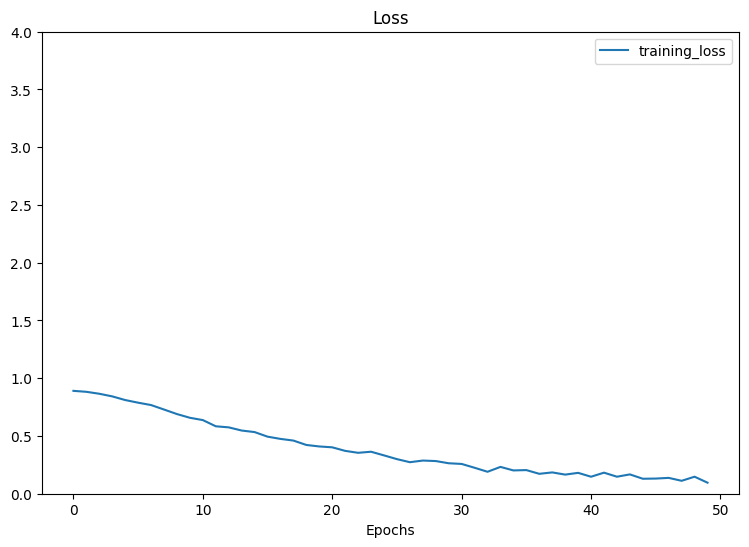

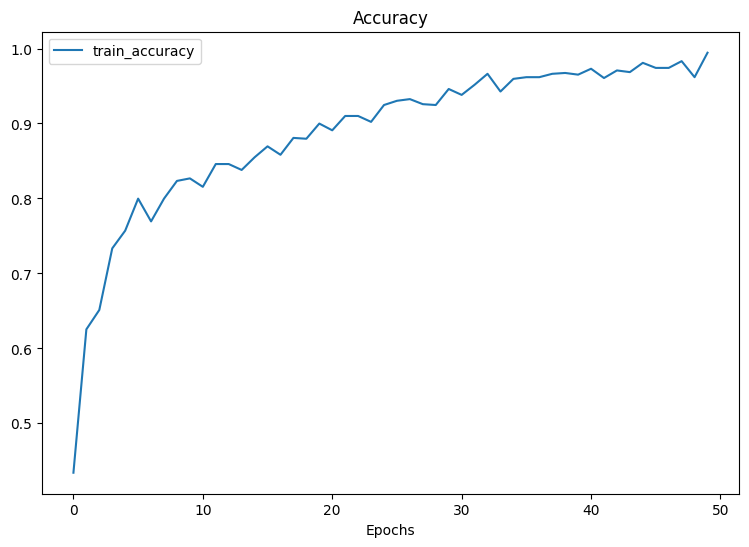

In [ ]:
# --- Train the model with the best hyperparameters and evaluate it on the test set ---

# Hyperparameters
BEST_LR = 1e-5 # learning rate
BEST_WD= 1e-4 # weight decay
BEST_NUM_EPOCHS = 50 # number of epochs for training
cosine_scheduler = False # Set to True if using cosine decay, False if using fixed learning rate
print(f"Using cosine decay: {cosine_scheduler}")

train_for_more_epochs = False

# Filepath to save/load the model
SAVED_MODEL_FILEPATH = "/home/diogommiranda/tese/outputs/best_model.pth"

# Load saved model or train anew
if train_for_more_epochs:
    model.load_state_dict(torch.load(SAVED_MODEL_FILEPATH, weights_only=True, map_location=device)) # load model to continue training for more epochs
    print(f"\nLoading model weights to continue training for more epochs.")
else:
    model = ResNet(
        block='basic',
        layers=[3, 4, 6, 3],
        block_inplanes=[64, 128, 256, 512],
        spatial_dims=3,
        n_input_channels=1,
        conv1_t_stride=2,
        num_classes=1,
        shortcut_type='B',
        bias_downsample=False
    )
    model.to(device)

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD)
#optimizer = torch.optim.SGD(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD, momentum=0.9, nesterov=True)

scheduler = None
if cosine_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7) # T_max=100 for 100 epochs (used in CV)

history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': []}

for epoch in tqdm(range(BEST_NUM_EPOCHS)):
    epoch_start_time = time.time()
    history['epoch'].append(epoch + 1)

    model.train()
    running_loss = 0.0
    train_pred_probs = []
    train_targets = []

    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        
        prob_outputs = torch.sigmoid(outputs)
        train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

    train_targets = np.array(train_targets).flatten()
    train_pred_probs = np.array(train_pred_probs).flatten()
    
    # Calculate training metrics for the epoch
    train_loss = running_loss / len(train_data.dataset)
    train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
    train_auc = roc_auc_score(train_targets, train_pred_probs)
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['train_auc'].append(train_auc)
        
    epoch_duration = time.time() - epoch_start_time
    print(f"    Epoch {epoch+1}/{BEST_NUM_EPOCHS} [{epoch_duration:.2f}s] - Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}")
    
    if scheduler:
        scheduler.step()

# Save the model if using fixed learning rate in case we want to continue training it
if not cosine_scheduler:
    torch.save(model.state_dict(), SAVED_MODEL_FILEPATH)
    print(f"Model saved to: {SAVED_MODEL_FILEPATH}")

plot_loss_curves(history)

# Evaluate the model on the test data
model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")


--- Evaluation Metrics on Test Set ---
Accuracy:    0.8145
Sensitivity: 0.7179
Specificity: 0.8671 
Balanced Accuracy (BACC): 0.7925
F1 Score (Weighted):      0.8136
Matthews Corr Coef (MCC): 0.5905
Area Under the Curve (AUC): 0.7925



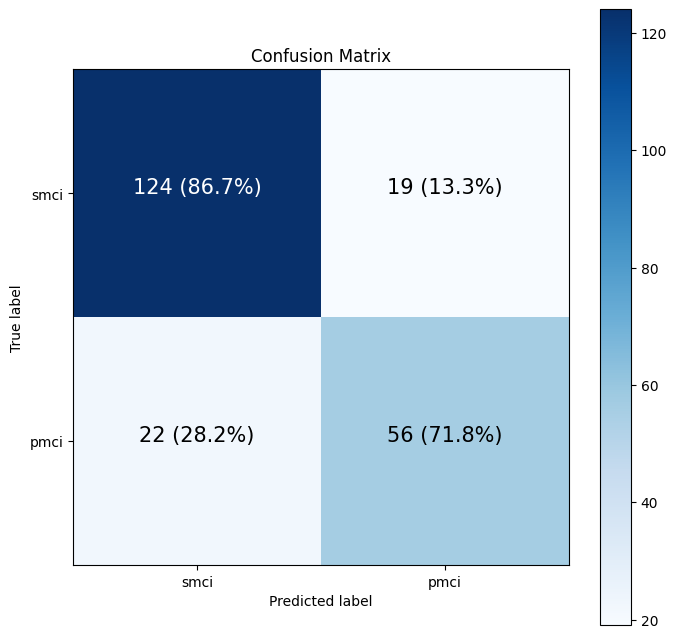

In [9]:
y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)


# Save the model

In [ ]:
save_option = False # Set to True to save the model, confusion matrix, and evaluation metrics

if save_option:
    
    # Configure the right path
    if USE_MASK:
        dir1 = "masked/"
    else:
        dir1 = "full_brain/"
    if cosine_scheduler:
        dir2 = "cosine_decay/"
    else:
        dir2 = "fixed_lr/"
        
    save_model_dir = "/home/diogommiranda/tese/outputs/torch/" + dir1 + dir2 + "CROSS_VALIDATION/saved_models/" + f"LR={BEST_LR:.1e}_WD={BEST_WD:.0e}"
    print(f"Saving model to: {save_model_dir}")
    os.makedirs(save_model_dir, exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), os.path.join(save_model_dir, "model.pth"))

    # Save the confusion matrix plot
    make_confusion_matrix(y_true=y_true,
                        y_pred=y_pred.round(),
                        classes=target_names,
                        figsize=(8, 8),
                        text_size=15,
                        save_dir=save_model_dir)

    # Save the test loss and accuracy and the evaluation metrics
    result_file_path = os.path.join(save_model_dir, "resultados.txt")
    with open(result_file_path, "w") as f:
        f.write(f"[{test_loss}, {test_acc}]\n\n")
        f.write("--- Evaluation Metrics on Test Set ---\n")
        f.write(f"Accuracy:    {accuracy:.4f}\n")
        f.write(f"Sensitivity: {sensitivity:.4f}\n")
        f.write(f"Specificity: {specificity:.4f}\n")
        f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
        f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
        f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
        f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

Saving model to: /home/diogommiranda/tese/outputs/torch/full_brain/fixed_lr/CROSS_VALIDATION/saved_models/LRRR=1.0e-05_WD=1e-04


  Train label counts: {0: 575, 1: 314}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8312
Test Loss: 0.7523062952638212, Test Acc: 0.8099547511312217

--- Evaluation Metrics on Test Set ---
Accuracy:    0.8100
Sensitivity: 0.7436
Specificity: 0.8462 
Balanced Accuracy (BACC): 0.7949
F1 Score (Weighted):      0.8105
Matthews Corr Coef (MCC): 0.5864
Area Under the Curve (AUC): 0.7949



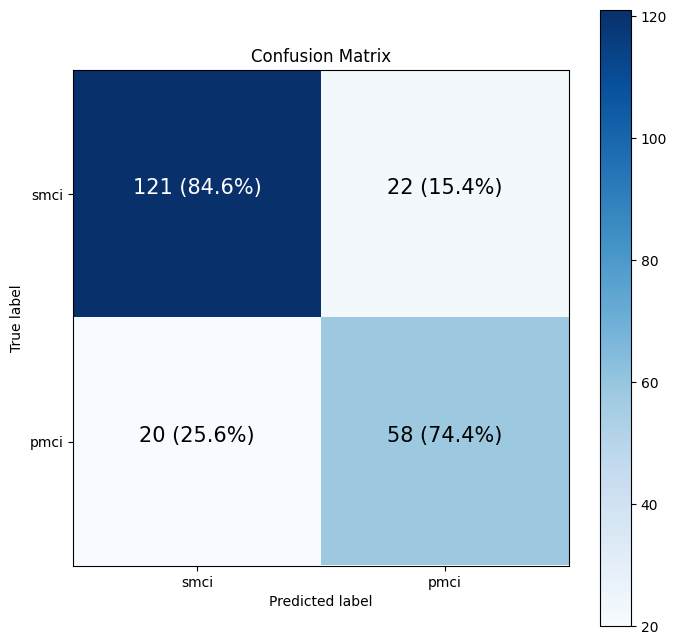

In [12]:
load_model = ResNet(
        block='basic',
        layers=[3, 4, 6, 3],
        block_inplanes=[64, 128, 256, 512],
        spatial_dims=3,
        n_input_channels=1,
        conv1_t_stride=2,
        num_classes=1,
        shortcut_type='B',
        bias_downsample=False
        )
load_model.to(device)
save_model_dir = "/home/diogommiranda/tese/outputs/torch/full_brain/fixed_lr/CROSS_VALIDATION/saved_models/LR=1.0e-05_WD=1e-04 (sgd)"
load_model.load_state_dict(torch.load(os.path.join(save_model_dir, "model.pth"), map_location=device))

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

# Evaluate the model on the test data
load_model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = load_model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)
